In [ ]:
#|default_exp calibration

# Calibration  

> Find the Compton peak first 

In [ ]:
#|hide 
%load_ext autoreload
%autoreload 2 

%matplotlib notebook

In [ ]:
#|hide 
import os 

In [ ]:
#|hide 
os.chdir('/home/frank/Work/DATA/maxrf4u-data/')

Inconveniently, MA-XRF data does not always include information about the energy calibration of the spectra. Although it is clear that the channel energies will roughly range between zero and the tube voltage, we need more precise numbers for the upcoming calculations. Thus, a very first step in the data analysis is to obtain a precise energy calibration in keV units (kilo-electron-Volt) for a given dataset. Fortunately, XRF spectra, (at least for drawings), typically have two clearly recognizable features that allow for energy calibration of the detector channels. 

## Two steps 

The automatic precise energy calibration is done in two steps.   

In the first step the dominant broad Compton peak is observed in the sum spectrum. The position of this peak can not be used for the calibration directly due to an unknown (detector angle specific) Compton shift, but it serves as a landmark. Right next to the Compton peak a small peak is found. In our lab an x-ray tube with a Rhodium anode is used. This peak can now be attributed to elastic scattering of the strong Rhodium K-alpha emission peak present in the x-ray tube spectrum at 20.21 keV.   

In the second step of the calibration process the iron K-alpha emission peak is located in the max spectrum. Essentially all artifacts like paper contain iron, with a known strong emission K-alpha line at 6.403 keV.  

As a first requisite step in any further data analysis the function `calibrate()` is called. The user is prompted to inspect and save the result.   

In [ ]:
from maxrf4u import calibrate, DataStack 

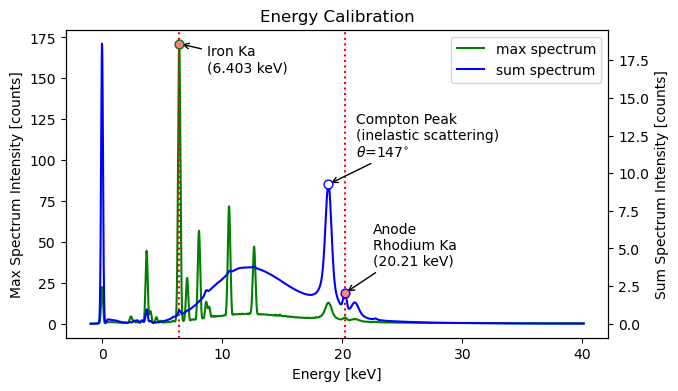

Write instrument energy calibration to datastack file [y/n]?  y



Writing channel energies (keV) to: RP-T-1898-A-3689.datastack
Also writing instrument Compton anode peak energy (keV) to: RP-T-1898-A-3689.datastack


In [ ]:
x_keVs = calibrate('RP-T-1898-A-3689.datastack', tube_keV=40)

In further analysis our stored energy calibration can now be accessed using the `.read('maxrf_energies')` method which returns an array with 4096 energy values. 

In [ ]:
ds = DataStack('RP-T-1898-A-3689.datastack')
x_keVs = ds.read('maxrf_energies')

print('Energies: ', x_keVs)
print(f'Number of energy channels: {len(x_keVs)}')

Energies:  [-0.98188629 -0.97185221 -0.96181812 ... 40.08763102 40.09766511
 40.1076992 ]
Number of energy channels: 4096


Now that we have an energy calibration, we can move to the next step in our data analysis... 

## FUNCTIONS 

In [ ]:
#|export 
 
import maxrf4u 
import matplotlib.pyplot as plt 
import numpy as np 
import scipy.signal as ssg 
import matplotlib.cm as cm 
import math

In [ ]:
#|export 

RHODIUM_Ka = 20.210105052526263 # Rh_KL3 
IRON_Ka = 6.4032016008004 # Fe_KL3 

def calibrate(datastack_file, anode='Rh', prominence=0.03, tube_keV=40, auto_write=False, manual_range=None): 
    '''Automatic two step energy energy calibration. 
    
    In step 1 a preliminary calibration is done assuming that the  
    sensor peak is located at 0 keV and the Rhodium anode Ka peak 
    is next to it's high and broad Compton scattering peak in the sum spectrum. 
    
    This preliminary calibration the enables the identification of Fe_Ka peak in 
    the max spectrum and a second precise calibration. 
    
    Asks user confirmation to store energy calibration in datastack file. 
    
    Returns: x_keVs
    '''


    # LOAD SPECTRA 
    ds = maxrf4u.DataStack(datastack_file)
    
    y_max = ds.read(ds.MAXRF_MAXSPECTRUM)
    y_sum = ds.read(ds.MAXRF_SUMSPECTRUM) 

    # IN CASE OF TROUBLE, SKIP AUTO CALIBRATION

    if manual_range is not None: 
        start, stop = manual_range 
        x_keVs = np.linspace(start, stop, num=len(y_max)) 
        maxrf4u.append(x_keVs, ds.MAXRF_ENERGIES, datastack_file) 

    # GO AHEAD WITH AUTO CALIBRATION 
    else: 
    
        assert anode == 'Rh', NotImplementedError('Sorry, still need to implement other anode materials!') 
        
    
        
        # LOCATE INSTRUMENT PEAK INDICES IN SUM SPECTRUM 
        
        left_peak_i, compton_peak_i, right_peak_i = find_instrument_peaks(y_sum, tube_keV=tube_keV, prominence=prominence) 
        
        # STEP 1: PRELIMINARY SENSOR + ANODE CALIBRATION TO LOCATE IRON Fe_Ka PEAK  
        
        left_keV = 0
        right_keV = RHODIUM_Ka 
        
        n_channels = len(y_sum) 
        x_indices = np.arange(n_channels)
    
        slope = (right_keV - left_keV) / (right_peak_i - left_peak_i) 
        offset = left_keV - slope * left_peak_i  
        keVs_precalib = slope * x_indices + offset 
    
        # STEP 2: PRECISE IRON Ka + ANODE CALIBRATION 
        
        max_peak_indices, shapes_dict = ssg.find_peaks(y_max, prominence=prominence) 
        peak_keVs_precalib = keVs_precalib[max_peak_indices]
    
        
        # needed to improve the algorithm to pick the largest peak 
        # in the iron region instead of nearest 
        # for now this is a quick hack that that is independent of the Compton stuff above 
        
        # now find index of peak nearest to Fe_Ka energy 
        #iron_peak_i = np.argmin((peak_keVs_precalib - IRON_Ka)**2) # old code does not work 
    
        # locate iron Ka channel index (new approach)    
        delta = 0.5 
        
        x_keVs_first_guess = np.linspace(-1, 40, n_channels)
        FeKa_region = ((x_keVs_first_guess > IRON_Ka - delta) * (x_keVs_first_guess < IRON_Ka + delta)).astype(int)
        
        left_peak_i = np.argmax(y_max * FeKa_region) 
    
        # calibrate again now with iron Ka left hand peak 
        
        #left_peak_i = max_peak_indices[iron_peak_i]
        left_keV = IRON_Ka
    
        slope = (right_keV - left_keV) / (right_peak_i - left_peak_i) 
        offset = left_keV - slope * left_peak_i  
        x_keVs = slope * x_indices + offset 
        
        # Calibration peak diagnostics 
        iron_xy = x_keVs[left_peak_i], y_max[left_peak_i]
        compton_xy = x_keVs[compton_peak_i], y_sum[compton_peak_i]
        anode_xy = x_keVs[right_peak_i], y_sum[right_peak_i] 
        
        theta = detector_angle(compton_xy[0], anode_xy[0])
        
        calib_peaks_x, calib_peaks_y = np.array([iron_xy, compton_xy, anode_xy]).T 
        
        # Create calibration plot 
        plt.ion()
    
        colors =  cm.tab10([0, 1, 2]) 
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[7, 4])
        ax2 = ax.twinx()
        line1, = ax.plot(x_keVs, y_max, label='max spectrum', color='green')
        line2, = ax2.plot(x_keVs, y_sum, label='sum spectrum', color='blue', alpha=0.5) 
        
        # adjusting upper ylim to fit compton peak height 
        # while trying to keep lower limit the same... 
        ax_ylim = ax.get_ylim()[1] 
        ax.set_ylim([0, ax_ylim])
        ax2.set_ylim([0, 2 * compton_xy[1]])
    
    
        # annotate iron in max spectrum 
        ax.axvline(iron_xy[0], linestyle=':', color='r')
        ax.annotate(f'Iron Ka \n({iron_xy[0]:.3f} keV)', iron_xy, xytext=[20, -20], 
                    textcoords='offset points', ha='left', 
                    arrowprops=dict(arrowstyle="->", facecolor='grey'))
        ax.scatter(*iron_xy, s=40, facecolor=[1, 0.5, 0.5], edgecolor='green', zorder=10) 
    
        ax.set_title('Energy Calibration')
        ax.set_xlabel('Energy [keV]')
        ax.set_ylabel('Max Spectrum Intensity [counts]')
    
    
        # annotate compton peak in sum spectrum 
        ax2.annotate('Compton Peak\n(inelastic scattering)\n' + 
                    r'$\theta$' + f'={int(theta)}' + r'$^{\circ}$', 
                    compton_xy, xytext=[20, 20], 
                    textcoords='offset points', ha='left', 
                    arrowprops=dict(arrowstyle="->", facecolor='grey'))
        ax2.scatter(*compton_xy, s=40, facecolor='white', edgecolor='blue', zorder=10)       
    
        # annotate anode peak in sum spectrum 
        ax2.axvline(anode_xy[0], linestyle=':', color='r')
        ax2.annotate(f'Anode\nRhodium Ka \n({anode_xy[0]:.2f} keV)', anode_xy, xytext=[20, 20], 
                    textcoords='offset points', ha='left', 
                    arrowprops=dict(arrowstyle="->", facecolor='grey'))
        ax2.scatter(*anode_xy, s=40, facecolor=[1, 0.5, 0.5], edgecolor=[0, 0, 1], zorder=10)        
    
        ax2.set_ylabel('Sum Spectrum Intensity [counts]')
    
        ax.legend(handles=[line1, line2], loc='upper right')
        
        # force updating plot 
        plt.pause(0.2)
        fig.canvas.draw()
            
        # write energies 
        if auto_write: 
            write = 'y'     
        else: 
            write = input('Write instrument energy calibration to datastack file [y/n]? ')
    
        if write == 'y': 
            print(f'\nWriting channel energies (keV) to: {datastack_file}')
            maxrf4u.append(x_keVs, ds.MAXRF_ENERGIES, datastack_file) 
            
            print(f'Also writing instrument Compton anode peak energy (keV) to: {datastack_file}')
            compton_peak_energy = x_keVs[compton_peak_i]
            maxrf4u.append(np.array([compton_peak_energy]), 'compton_peak_energy', datastack_file)
            
    return x_keVs


def detector_angle(keV0, keV1): 
    '''Calculate detector scatter angle `theta` (degrees) 
    
    From Compton peak energy `keV0` and anode energy `keV1`, assuming a single scattering event. 
    
    Returns: theta (degrees)'''
    
    assert keV0 < keV1, 'Compton energy should be less then anode energy'

    # constants 
    e = 1.602e-19 # electron charge
    pi = math.pi
    h = 6.62607e-34 # Planck constant 
    m0 = 9.10939e-31 # electron mass 
    c = 2.998e8 # speed of light 
    
    
    # convert keV to Joule 
    E0 = 1000 * keV0 * e 
    E1 = 1000 * keV1 * e 

    theta = (180 / pi) * np.arccos(1 - m0 * c**2 * (1/E0 - 1/E1))

    return theta 


def find_instrument_peaks(y_sum, prominence=0.03, tube_keV=40):  
    '''Locate key instrument peaks: 
    
              1) left hand sensor peak index  
              2) anode Compton peak index  
              3) right hand (rhodium) anode Ka peak index  
              
              in sum spectrum `y_sum`. 
    
    Assumes anode material is rhodium, and Compton peak energy is 
    first peak below (uncalibrated) 20 keV, based on tube keV.     
    
    Returns: [left_peak_i, compton_peak_i, right_peak_i] 
    '''
    
    # find all prominent peaks in sum spectrum 
    n_channels = len(y_sum) 
    x_indices = np.arange(n_channels)
    sum_peak_indices, shapes_dict = ssg.find_peaks(y_sum, prominence=prominence)
    
    # Sensor peak 
    # assume sensor peak index is first peak index in list    
    left_peak_i = sum_peak_indices[0] 


    # Compton peak (maximum in Compton region approach) 
    # this is an attempt to fix the 'below 20keV approach' 

    # start by assuming between 0-40 keV 
    x_approx_keVs = np.linspace(0, tube_keV, n_channels) 

    # now assume that the Compton peak is largest in the Compton region 
    is_compton_region = (x_approx_keVs > 18.5) * (x_approx_keVs < 22) 
    compton_peak_i = int(np.argmax(y_sum * is_compton_region))
    
    # Compton peak (old approach: did not work for Sous-Bois data)
    # assume that Compton peak is first peak below 20 keV 
    # in `tube_keV` based uncalibrated spectrum 
    # i.e. with energies ranging from 0 to `tube_keV` 

    #peak_approx_keVs = x_approx_keVs[sum_peak_indices] # approximate peak keVs from tube keV 
    #is_below20keV = peak_approx_keVs < 20 
    
    #i = np.argmax(peak_approx_keVs[is_below20keV]) # peak number 
    #compton_peak_i = sum_peak_indices[i]
    
    # Anode peak 
    # find anode peak channel index right next to Compton peak    
    right_peak_i = sum_peak_indices[list(sum_peak_indices).index(compton_peak_i) + 1] 
    
    return [left_peak_i, compton_peak_i, right_peak_i]
      



def compton_shift(keV_in, theta): 
    '''Compute Compton shift for photon energies `keV_in` and scatter angle `theta`. 
    
    Assuming single scattering. 
    
    Returns: keV_out'''
    

    # See: https://en.wikipedia.org/wiki/Compton_scattering 

    # constants 
    e = 1.602e-19 # electron charge
    pi = math.pi
    h = 6.62607e-34 # Planck constant 
    m0 = 9.10939e-31 # electron mass 
    c = 2.998e8 # speed of light

    # convert keV to Joule 
    E_in = 1000 * keV_in * e 
    
    # convert theta to radians 
    theta = pi * theta / 180
    
    E_out = E_in / (1 + (E_in / (m0 * c**2)) * (1 - np.cos(theta))) 
    
    keV_out = E_out / (1000 * e) 
    
    return keV_out 
    